In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data

#rebalancing 전략: ex) 1:1로 자산율 유지 

In [2]:
def getCloseDataPandas(ticker, start, end=None):
    return data.get_data_yahoo(ticker, start, end)["Close"]


def getCloseDataFdr(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)["Close"]

In [3]:
def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]

def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)


def getPortfolioResult(closeDataSet, weight=None):
    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    print(weight)

    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    
def getEval(cumRet):
    cagr = cumRet.iloc[-1] ** (252/len(cumRet))

    dd = (cumRet.cummax() - cumRet) / cumRet.cummax() * 100
    mdd = dd.max()
     
    plt.figure(figsize=(15, 5))
    plt.plot(-dd, label="spy")
    
    print(f"return: {cumRet.iloc[-1]} \n cagr: {cagr} \n mdd: {mdd}")
    
    return cagr, dd, mdd



In [4]:
kodex200 = getCloseDataFdr("069500", "2022")
kodex10bond = getCloseDataFdr("152380", "2022")

closeDataSet = pd.concat([kodex200, kodex10bond], axis=1)
closeDataSet.columns = ["kodex200", "kodex10bond"]
closeDataSet.dropna(inplace=True)
closeDataSet

,kodex200,kodex10bond
Date,,
2022-01-03,39245,68415
2022-01-04,39221,68450
2022-01-05,38662,68030
2022-01-06,38273,67480
2022-01-07,38754,67460
...,...,...
2022-09-30,28275,60035
2022-10-04,28960,60815
2022-10-05,28965,60495


In [5]:
closeDataSet0 = pd.concat([kodex200, kodex10bond], axis=0)
closeDataSet0.columns = ["kodex200", "kodex10bond"]
closeDataSet0.dropna(inplace=True)
closeDataSet0

Date
2022-01-03    39245
2022-01-04    39221
2022-01-05    38662
2022-01-06    38273
2022-01-07    38754
              ...  
2022-09-30    60035
2022-10-04    60815
2022-10-05    60495
2022-10-06    60350
2022-10-07    59885
Name: Close, Length: 376, dtype: int64

In [6]:
cpCloseDataSet = closeDataSet.copy()
cpCloseDataSet["year"] = cpCloseDataSet.index.year
cpCloseDataSet["month"] = cpCloseDataSet.index.month

rebalancingDate = cpCloseDataSet.drop_duplicates(["year", "month"], keep="last").index.date
rebalancingDate

array([datetime.date(2022, 1, 28), datetime.date(2022, 2, 28),
       datetime.date(2022, 3, 31), datetime.date(2022, 4, 29),
       datetime.date(2022, 5, 31), datetime.date(2022, 6, 30),
       datetime.date(2022, 7, 29), datetime.date(2022, 8, 31),
       datetime.date(2022, 9, 30), datetime.date(2022, 10, 7)],
      dtype=object)

In [7]:
defaultWeight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
defaultWeight

[0.5, 0.5]

In [8]:
monthlyWeight = pd.DataFrame([defaultWeight] * len(rebalancingDate), index=rebalancingDate)
monthlyWeight.columns = ["kodex200", "kodex10bond"]
monthlyWeight

,kodex200,kodex10bond
2022-01-28,0.5,0.5
2022-02-28,0.5,0.5
2022-03-31,0.5,0.5
2022-04-29,0.5,0.5
2022-05-31,0.5,0.5
2022-06-30,0.5,0.5
2022-07-29,0.5,0.5
2022-08-31,0.5,0.5
2022-09-30,0.5,0.5
2022-10-07,0.5,0.5


In [9]:
start = rebalancingDate[0]
print("start: ", start)

for end in rebalancingDate[1:]:
    weight = monthlyWeight.loc[start] #당월 리밸런싱 비율
    priceData = closeDataSet.loc[start:end]
    cumRet = getCumulativeReturn(priceData)
    weightCumRet = weight * cumRet

    print(f"Date: {end}\nweight: {weight}\npriceData: {priceData}\ncumRet: {cumRet}\nwightCumRet: {weightCumRet} \n\n")
    start = end
    

start:  2022-01-28
Date: 2022-02-28
weight: kodex200       0.5
kodex10bond    0.5
Name: 2022-01-28, dtype: float64
priceData:             kodex200  kodex10bond
Date                             
2022-01-28     35656        66970
2022-02-03     36000        67090
2022-02-04     36472        66785
2022-02-07     36099        66710
2022-02-08     36168        66120
2022-02-09     36670        66400
2022-02-10     36974        66410
2022-02-11     36630        66080
2022-02-14     36138        66385
2022-02-15     35917        66365
2022-02-16     36566        66425
2022-02-17     36803        66440
2022-02-18     36665        66330
2022-02-21     36689        66085
2022-02-22     36158        66400
2022-02-23     36286        66380
2022-02-24     35337        66950
2022-02-25     35735        66650
2022-02-28     36005        66685
cumRet:             kodex200  kodex10bond
Date                             
2022-01-28  1.000000     1.000000
2022-02-03  1.009648     1.001792
2022-02-04  1.02

누적수익률:             kodex200  kodex10bond
Date                             
2022-01-28  0.500000     0.500000
2022-02-03  0.504824     0.500896
2022-02-04  0.511443     0.498619
2022-02-07  0.506212     0.498059
2022-02-08  0.507180     0.493654
2022-02-09  0.514219     0.495744
2022-02-10  0.518482     0.495819
2022-02-11  0.513658     0.493355
2022-02-14  0.506759     0.495632
2022-02-15  0.503660     0.495483
2022-02-16  0.512761     0.495931
2022-02-17  0.516084     0.496043
2022-02-18  0.514149     0.495222
2022-02-21  0.514486     0.493393
2022-02-22  0.507039     0.495744
2022-02-23  0.508834     0.495595
2022-02-24  0.495527     0.499851
2022-02-25  0.501108     0.497611
2022-02-28  0.504894     0.497872
 갱신후 총자산: 1.0027661685606013

누적수익률:             kodex200  kodex10bond
Date                             
2022-02-28  0.501383     0.501383
2022-03-02  0.499336     0.503939
2022-03-03  0.508847     0.502248
2022-03-04  0.500979     0.502060
2022-03-07  0.489741     0.500556
2022

<Figure size 1200x800 with 0 Axes>

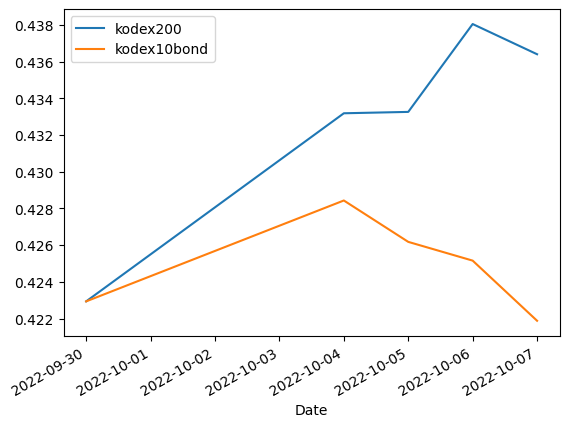

In [10]:
start = rebalancingDate[0]
totalAsset = 1

for end in rebalancingDate[1:]:
    weight = monthlyWeight.loc[start]
    priceData = closeDataSet.loc[start:end]
    cumRet = getCumulativeReturn(priceData)
    weightedCumRet = weight * cumRet

    netCumRet = totalAsset * weightedCumRet
    start = end
    totalAsset = netCumRet.iloc[-1].sum()
    print(f"누적수익률: {netCumRet}\n 갱신후 총자산: {totalAsset}\n")
    
plt.figure(figsize=(12, 8))
netCumRet.plot(label="netCumRet")
plt.legend()
plt.show()

<Figure size 1200x800 with 0 Axes>

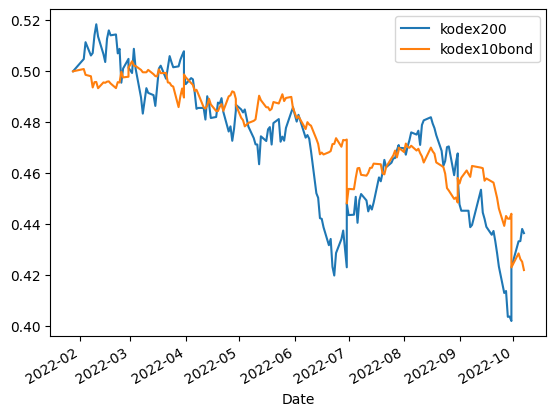

In [11]:
portfolio = pd.DataFrame()
totalAsset = 1
start = rebalancingDate[0]

for end in rebalancingDate[1:]:
    weight = monthlyWeight.loc[start]
    priceData = closeDataSet.loc[start:end]
    cumRet = getCumulativeReturn(priceData)
    weightCumRet = weight * cumRet
    netCumRet = totalAsset * weightCumRet

    start = end
    totalAsset = netCumRet.iloc[-1].sum()
    portfolio = pd.concat([portfolio, netCumRet])

plt.figure(figsize=(12, 8))
portfolio.plot(label="portfolio")
plt.legend()
plt.show()

In [12]:
portfolio.index.duplicated(keep="last")
portfolio.loc[~portfolio.index.duplicated(keep="last")]
portfolio

,kodex200,kodex10bond
Date,,
2022-01-28,0.500000,0.500000
2022-02-03,0.504824,0.500896
2022-02-04,0.511443,0.498619
2022-02-07,0.506212,0.498059
2022-02-08,0.507180,0.493654
...,...,...
2022-09-30,0.422937,0.422937
2022-10-04,0.433183,0.428432
2022-10-05,0.433258,0.426178


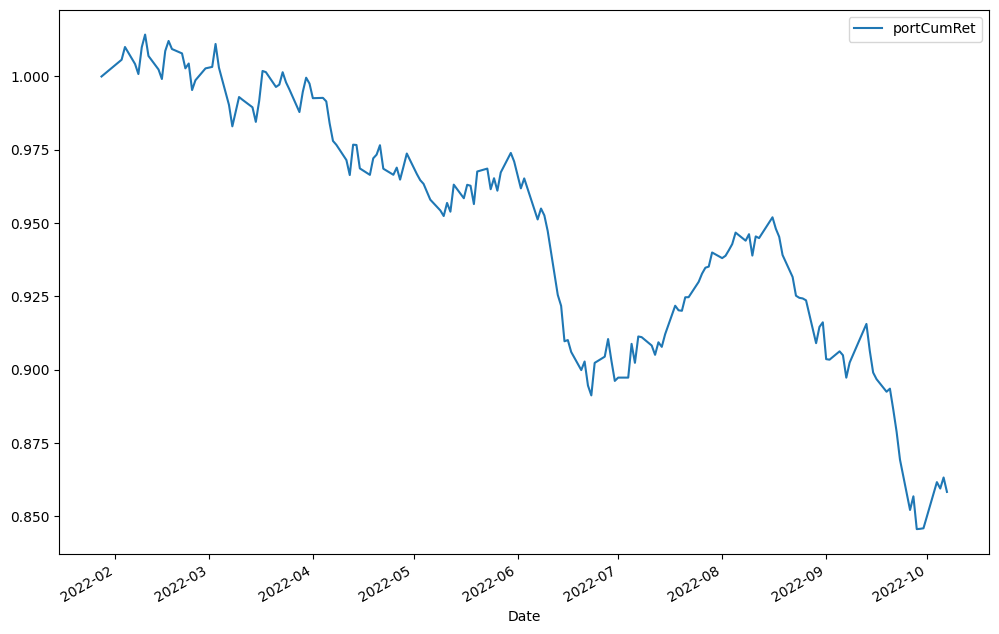

In [13]:
portCumRet = portfolio.sum(axis=1)
plt.figure(figsize=(12, 8))
portCumRet.plot(label="portCumRet")
plt.legend()
plt.show()

In [14]:
def getRebalancingDate(closeDataSet, period="month"):
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data["year"] = data.index.year
    data["month"] = data.index.month

    #월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(["year", "month"], keep="last").index

    #분기말 리밸런싱 
    if period == "quarter":
        quarter = [3, 6, 9, 12]
        data = data.loc[data["month"].isin(quarter)]
        rebalancingDate = data.drop_duplicates(["year", "month"], keep="last").index

    #연말 리밸런싱
    if period == "year":
        rebalancingDate = data.drop_duplicates(["year"], keep="last").index

    return rebalancingDate    
    

In [15]:
def getRebalancingPortfolio(closeDataSet, period="month", weightDf=None):
    #자산별 비중, 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period)
        
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)],
                                index=rebalancingDate,
                                columns=closeDataSet.columns)

    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period)

    portfolio = pd.DataFrame()

    totalAsset = 1
    start = rebalancingDate[0]
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start]
        priceData = closeDataSet.loc[start:end]
        cumRet = getCumulativeReturn(priceData)
        weightCumRet = weight * cumRet
        netCumRet = totalAsset * weightCumRet

        start = end
        totalAsset = netCumRet.iloc[-1].sum()
        portfolio = pd.concat([portfolio, netCumRet])

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep="last")]
    portfolioCumulativeReturn = portfolio.sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1))

    return portfolioDayReturn, portfolioCumulativeReturn
    
        

In [16]:
stockETF = getCloseDataPandas("IEF", "2002", "2022-6-17")
bondETF = getCloseDataPandas("IEF", "2022", "2022-6-17")
closeDataSet = pd.concat([stockETF, bondETF], axis=1)
closeDataSet.columns = ["stocketf", "bondetf"]
closeDataSet.dropna(inplace=True)
closeDataSet

,stocketf,bondetf
Date,,
2021-12-31,115.000000,115.000000
2022-01-03,113.930000,113.930000
2022-01-04,113.870003,113.870003
2022-01-05,113.389999,113.389999
2022-01-06,113.110001,113.110001
...,...,...
2022-06-13,98.940002,98.940002
2022-06-14,98.150002,98.150002
2022-06-15,99.519997,99.519997


In [17]:
rebalancingDate = getRebalancingDate(closeDataSet)
rebalancingDate

DatetimeIndex(['2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31',
               '2022-04-29', '2022-05-31', '2022-06-17'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [18]:
rebalPortfolioDayReturn, rebalPortfolioCumReturn = getRebalancingPortfolio(closeDataSet)
print(rebalPortfolioDayReturn, rebalPortfolioCumReturn)

Date
2021-12-31         NaN
2022-01-03    0.990696
2022-01-04    0.999473
2022-01-05    0.995785
2022-01-06    0.997531
                ...   
2022-06-13    0.982230
2022-06-14    0.992015
2022-06-15    1.013958
2022-06-16    1.006531
2022-06-17    1.000299
Length: 117, dtype: float64 Date
2021-12-31    1.000000
2022-01-03    0.990696
2022-01-04    0.990174
2022-01-05    0.986000
2022-01-06    0.983565
                ...   
2022-06-13    0.860348
2022-06-14    0.853478
2022-06-15    0.865391
2022-06-16    0.871043
2022-06-17    0.871304
Length: 117, dtype: float64


rebalanced portfolio cumret: 1.0002994786846886
return: 0.8713043212890627 
 cagr: 0.7432503120287003 
 mdd: 14.652172586192247


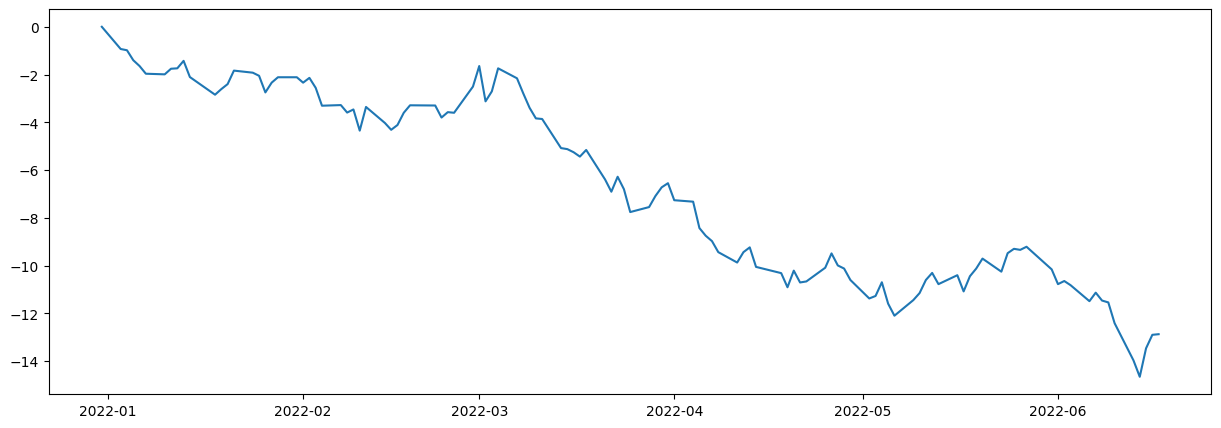

In [19]:
stockDayReturn = getDayReturn(stockETF.loc[rebalancingDate[0]:])
stockCumReturn = getCumulativeReturn(stockETF.loc[rebalancingDate[0]:])

print(f"rebalanced portfolio cumret: {rebalPortfolioDayReturn.iloc[-1]}")
rebalCagr, rebalDD, rebalMDD = getEval(rebalPortfolioCumReturn)